# Import necessary libraries and setup

In [ ]:
"""

Author: Vaibhav Sharma, Shreya Khantal, Prasanna Saxena
Team Name: Team Cygnus
Team Members: Vaibhav Sharma, Shreya Khantal, Prasanna Saxena
Leaderboard Rank: 91

"""


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import random
from tqdm.notebook import tqdm
import copy

# For preprocessing and modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Check if GPU is available (we ran it on GPU P100 when finding the best model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Paths to load dataset
DATA_DIR = "/kaggle/input/soil-classification/soil_classification-2025"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train")
TEST_IMG_DIR = os.path.join(DATA_DIR, "test")


Using device: cuda


# Load and examine the data

In [2]:
# We're loading the CSV files containing training labels and test IDs
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_ids.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

# Display dataset info to understand what we're working with
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print("\nTrain DF Head:")
print(train_df.head())

# We check for duplicates to ensure data integrity
print("\nDuplicate images in train set:", train_df['image_id'].duplicated().sum())

# Check for missing values that might affect our model
print("\nMissing values in train set:")
print(train_df.isnull().sum())

# Label encode soil types for model training
le = LabelEncoder()
train_df['soil_label'] = le.fit_transform(train_df['soil_type'])

# Create mapping dictionary for later use
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
inv_label_mapping = {v: k for k, v in label_mapping.items()}

print("\nSoil Type Mapping:")
for soil_type, label in label_mapping.items():
    print(f"{soil_type} => {label}")

Train Shape: (1222, 2)
Test Shape: (341, 1)

Train DF Head:
           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil

Duplicate images in train set: 0

Missing values in train set:
image_id     0
soil_type    0
dtype: int64

Soil Type Mapping:
Alluvial soil => 0
Black Soil => 1
Clay soil => 2
Red soil => 3


# Analyze class distribution

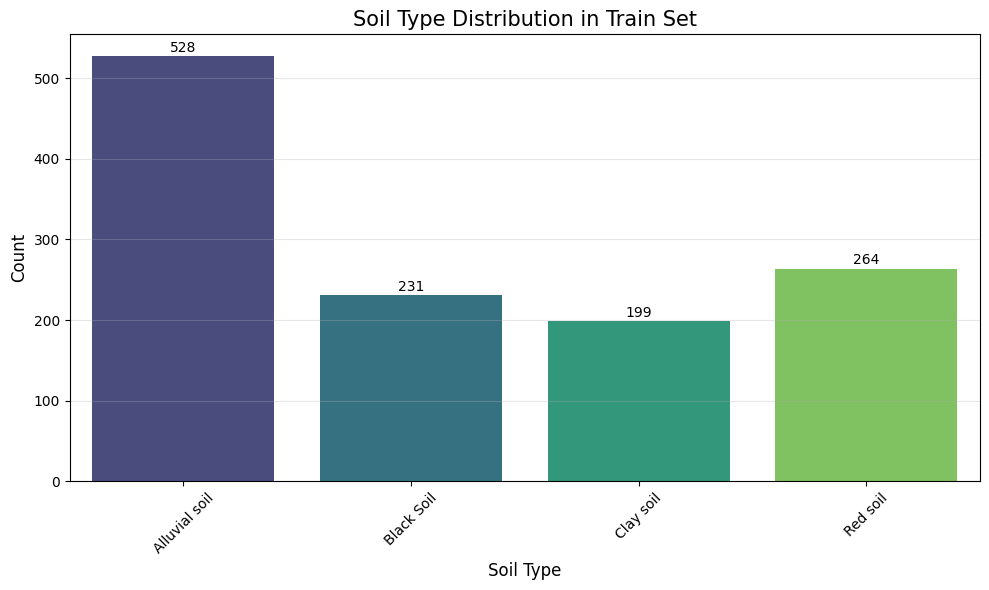


Class Counts:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64
Class Statistics:
Minimum samples: 199 (Class: Clay soil)
Maximum samples: 528 (Class: Alluvial soil)
Imbalance Ratio (max/min): 2.65
Mean samples per class: 305.50
Standard deviation: 150.69
Coefficient of variation: 0.49

 Class imbalance detected. We will implement oversampling and class weights.


In [3]:
# We need to understand the class distribution to determine if we need to handle imbalance
plt.figure(figsize=(10, 6))
class_counts = train_df['soil_type'].value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Soil Type Distribution in Train Set", fontsize=15)
plt.xlabel("Soil Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)

# Add count labels on bars for better readability
for i, count in enumerate(class_counts.values):
    ax.text(i, count + 5, str(count), ha='center', fontsize=10)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate detailed class balance statistics
class_counts = train_df['soil_type'].value_counts()
print("\nClass Counts:")
print(class_counts)

min_class = class_counts.min()
max_class = class_counts.max()
imbalance_ratio = max_class / min_class
mean_samples = class_counts.mean()
std_samples = class_counts.std()

print(f"Class Statistics:")
print(f"Minimum samples: {min_class} (Class: {class_counts.idxmin()})")
print(f"Maximum samples: {max_class} (Class: {class_counts.idxmax()})")
print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
print(f"Mean samples per class: {mean_samples:.2f}")
print(f"Standard deviation: {std_samples:.2f}")
print(f"Coefficient of variation: {std_samples/mean_samples:.2f}")

# Decide if we need to address class imbalance
if imbalance_ratio > 1.5:
    print("\n Class imbalance detected. We will implement oversampling and class weights.")
else:
    print("\n Class distribution looks reasonably balanced.")

# Visualize sample images from each soil type

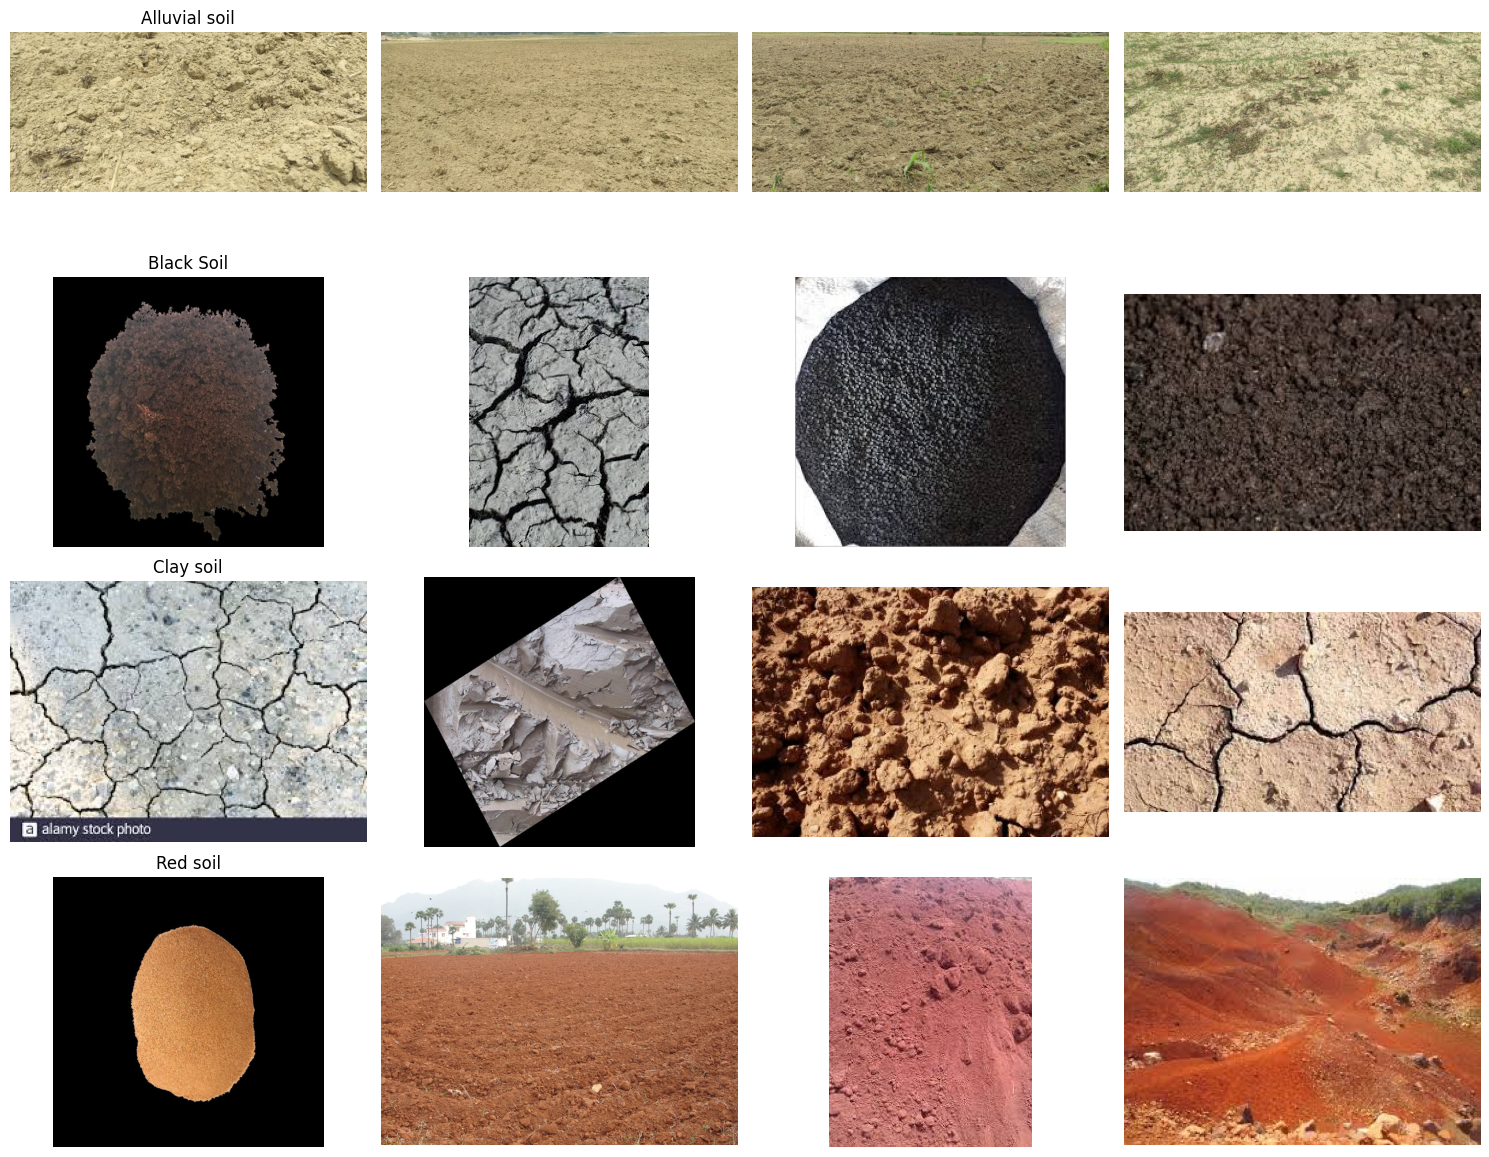

In [4]:
# We create a function to display sample images from each class
def display_images_by_class(df, img_dir, num_per_class=3, figsize=(15, 12)):
    classes = df['soil_type'].unique()
    fig, axes = plt.subplots(len(classes), num_per_class, figsize=figsize)
    
    for i, soil_type in enumerate(sorted(classes)):
        # Get random images for this class
        class_images = df[df['soil_type'] == soil_type]['image_id'].values
        selected_images = np.random.choice(class_images, min(num_per_class, len(class_images)), replace=False)
        
        for j, img_id in enumerate(selected_images):
            img_path = os.path.join(img_dir, img_id)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            # Only add soil type label to the first image in each row
            if j == 0:
                axes[i, j].set_title(f"{soil_type}", fontsize=12)
                
    plt.tight_layout()
    plt.show()

# We display random images from each class to understand the visual differences
display_images_by_class(train_df, TRAIN_IMG_DIR, num_per_class=4)


# Analyze image dimensions

Analyzing images:   0%|          | 0/300 [00:00<?, ?it/s]

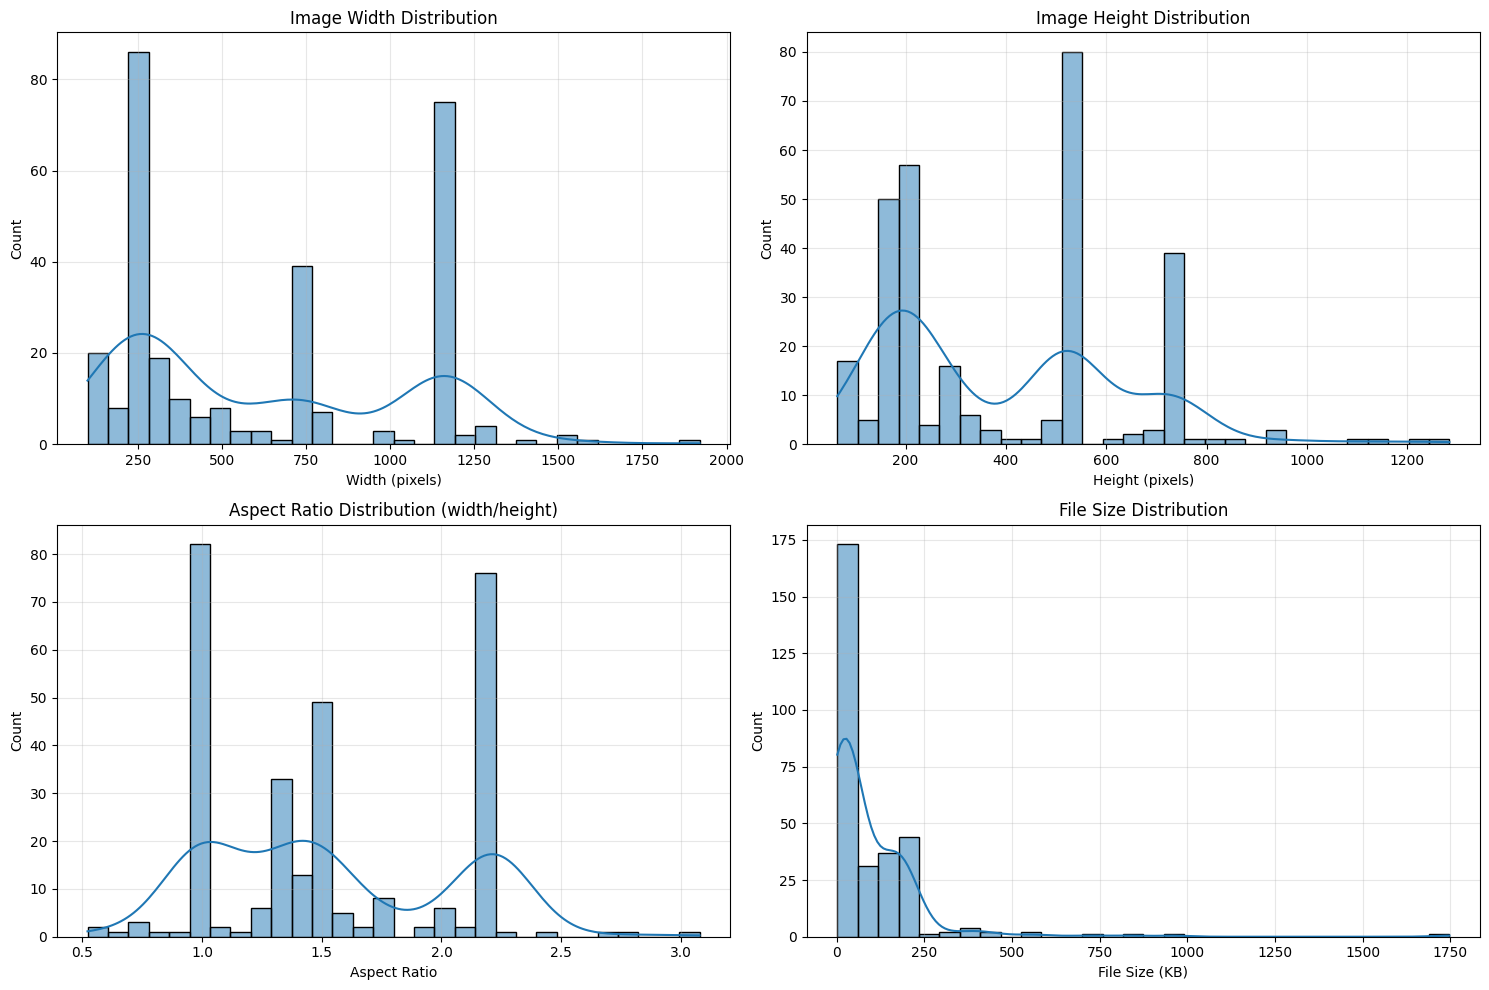

Width - Min: 100, Max: 1920, Mean: 622.25, Median: 490.0
Height - Min: 64, Max: 1284, Mean: 397.35, Median: 336.5
Aspect Ratio - Min: 0.52, Max: 3.08, Mean: 1.54
File Size (KB) - Min: 2.07, Max: 1747.58, Mean: 94.59


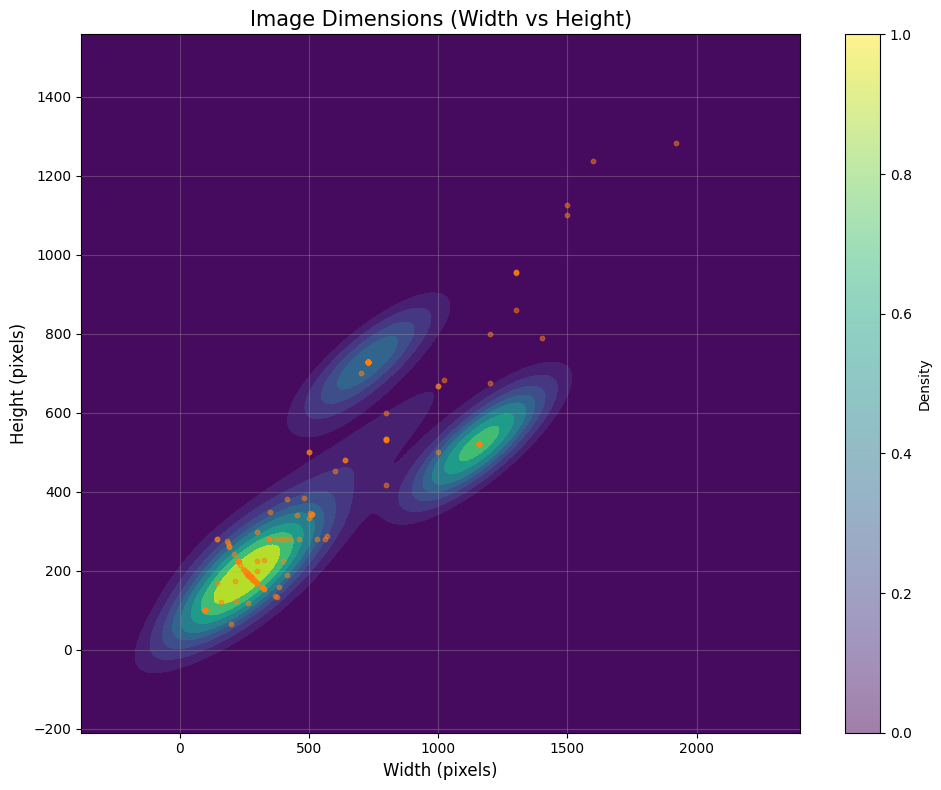

In [5]:
# We need to understand the image dimensions to design our preprocessing pipeline
def get_image_dimensions(img_dir, image_ids, max_samples=300):
    """Get dimensions of images"""
    dimensions = []
    aspect_ratios = []
    file_sizes = []
    
    # Sample if too many images
    if len(image_ids) > max_samples:
        image_ids = np.random.choice(image_ids, max_samples, replace=False)
    
    for img_id in tqdm(image_ids, desc="Analyzing images"):
        img_path = os.path.join(img_dir, img_id)
        try:
            img = Image.open(img_path)
            width, height = img.size
            dimensions.append((width, height))
            aspect_ratios.append(width / height)
            file_sizes.append(os.path.getsize(img_path) / 1024)  # Size in KB
        except Exception as e:
            print(f"Error processing {img_id}: {e}")
    
    return dimensions, aspect_ratios, file_sizes

# Analyze a sample of training images
dimensions, aspect_ratios, file_sizes = get_image_dimensions(
    TRAIN_IMG_DIR, train_df['image_id'].values, max_samples=300
)

# Extract width and height for analysis
widths, heights = zip(*dimensions)

# Plot dimension distributions to understand image characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Width distribution
sns.histplot(widths, bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Image Width Distribution", fontsize=12)
axes[0, 0].set_xlabel("Width (pixels)")
axes[0, 0].grid(alpha=0.3)

# Height distribution
sns.histplot(heights, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Image Height Distribution", fontsize=12)
axes[0, 1].set_xlabel("Height (pixels)")
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
sns.histplot(aspect_ratios, bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Aspect Ratio Distribution (width/height)", fontsize=12)
axes[1, 0].set_xlabel("Aspect Ratio")
axes[1, 0].grid(alpha=0.3)

# File size distribution
sns.histplot(file_sizes, bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("File Size Distribution", fontsize=12)
axes[1, 1].set_xlabel("File Size (KB)")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print dimension statistics to guide our preprocessing decisions
print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}, Median: {np.median(widths)}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}, Median: {np.median(heights)}")
print(f"Aspect Ratio - Min: {min(aspect_ratios):.2f}, Max: {max(aspect_ratios):.2f}, Mean: {np.mean(aspect_ratios):.2f}")
print(f"File Size (KB) - Min: {min(file_sizes):.2f}, Max: {max(file_sizes):.2f}, Mean: {np.mean(file_sizes):.2f}")

# Dimension scatter plot with heatmap to visualize dimension clusters
plt.figure(figsize=(10, 8))
sns.kdeplot(x=widths, y=heights, cmap="viridis", fill=True, thresh=0)
plt.scatter(widths, heights, alpha=0.5, s=10)
plt.title("Image Dimensions (Width vs Height)", fontsize=15)
plt.xlabel("Width (pixels)", fontsize=12)
plt.ylabel("Height (pixels)", fontsize=12)
plt.grid(alpha=0.3)
plt.colorbar(label="Density")
plt.tight_layout()
plt.show()


# Analyze color distribution by soil type

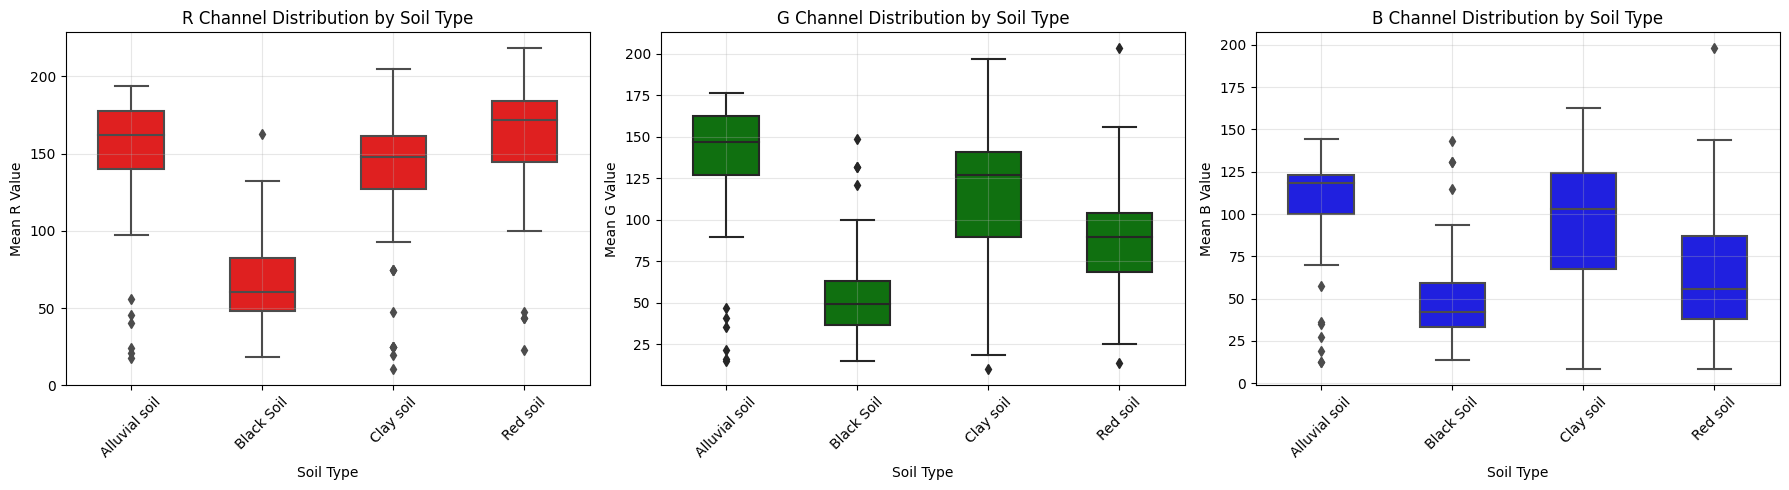

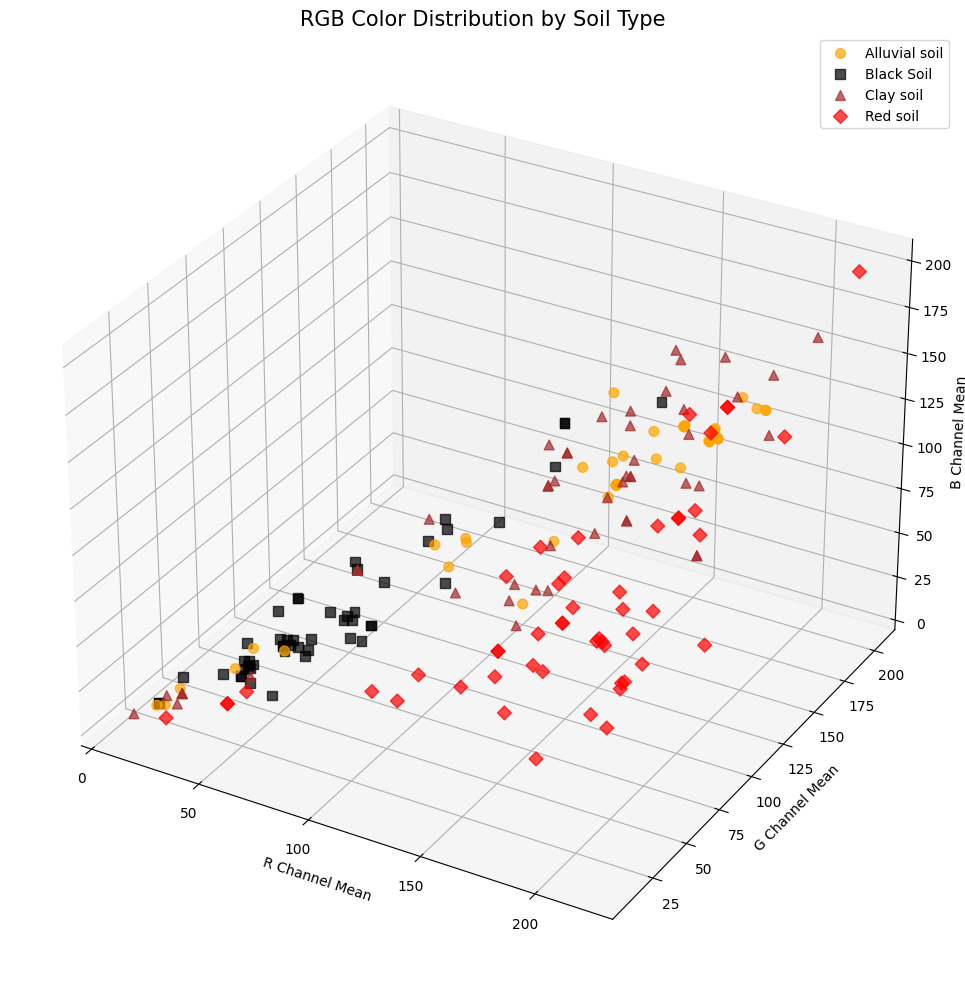

In [6]:
# Color features could be important for soil classification
def analyze_color_distribution(df, img_dir, num_samples_per_class=50):
    soil_types = sorted(df['soil_type'].unique())
    color_means = {soil_type: {'R': [], 'G': [], 'B': []} for soil_type in soil_types}
    
    for soil_type in soil_types:
        # Get sample images for this class
        class_images = df[df['soil_type'] == soil_type]['image_id'].values
        selected_images = np.random.choice(
            class_images, 
            min(num_samples_per_class, len(class_images)), 
            replace=False
        )
        
        for img_id in selected_images:
            img_path = os.path.join(img_dir, img_id)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                
                # Calculate mean color values
                mean_r = np.mean(img[:, :, 0])
                mean_g = np.mean(img[:, :, 1])
                mean_b = np.mean(img[:, :, 2])
                
                color_means[soil_type]['R'].append(mean_r)
                color_means[soil_type]['G'].append(mean_g)
                color_means[soil_type]['B'].append(mean_b)
            except Exception as e:
                print(f"Error processing {img_id}: {e}")
    
    return color_means

# Get color distributions to see if different soil types have distinctive colors
color_means = analyze_color_distribution(train_df, TRAIN_IMG_DIR)

# Plot color distributions by soil type
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
channels = ['R', 'G', 'B']
colors = ['red', 'green', 'blue']

for i, (channel, color) in enumerate(zip(channels, colors)):
    data = []
    labels = []
    
    for soil_type in sorted(color_means.keys()):
        data.extend(color_means[soil_type][channel])
        labels.extend([soil_type] * len(color_means[soil_type][channel]))
    
    sns.boxplot(x=labels, y=data, ax=axes[i], color=color, width=0.5)
    axes[i].set_title(f"{channel} Channel Distribution by Soil Type", fontsize=12)
    axes[i].set_xlabel("Soil Type", fontsize=10)
    axes[i].set_ylabel(f"Mean {channel} Value", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3D plot of RGB values to visualize color clustering by soil type
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['orange', 'black', 'brown', 'red']  # Representing each soil type
markers = ['o', 's', '^', 'D']  # Different markers for each soil type

for i, soil_type in enumerate(sorted(color_means.keys())):
    r_means = color_means[soil_type]['R']
    g_means = color_means[soil_type]['G']
    b_means = color_means[soil_type]['B']
    
    ax.scatter(r_means, g_means, b_means, c=colors[i], marker=markers[i], 
               s=50, alpha=0.7, label=soil_type)

ax.set_xlabel('R Channel Mean', fontsize=10)
ax.set_ylabel('G Channel Mean', fontsize=10)
ax.set_zlabel('B Channel Mean', fontsize=10)
ax.set_title('RGB Color Distribution by Soil Type', fontsize=15)
ax.legend()
plt.tight_layout()
plt.show()


# Define dataset class and transformations

Dataset Mean: [0.51927466 0.41479487 0.32805257], Std: [0.27258596 0.25516909 0.22726975]
Augmentation Examples: Alluvial soil


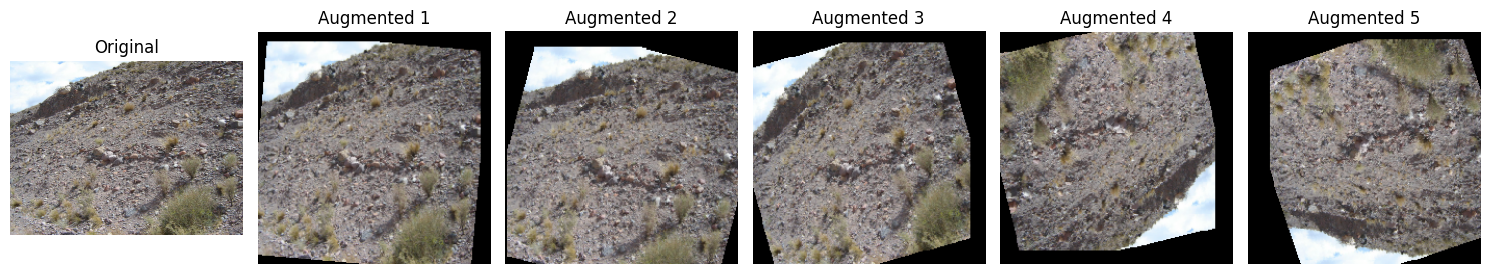

Augmentation Examples: Black Soil


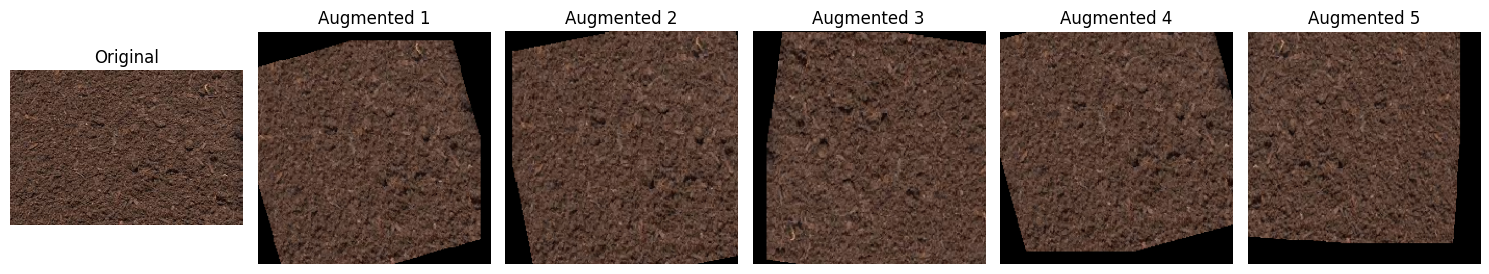

Augmentation Examples: Clay soil


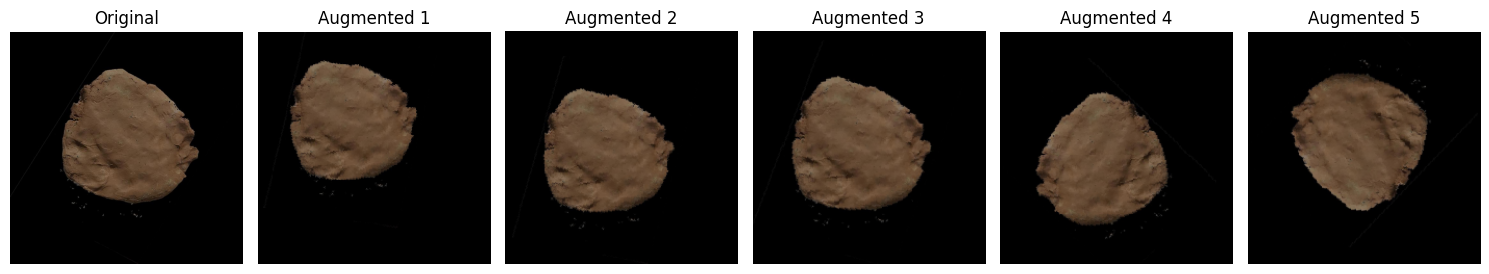

Augmentation Examples: Red soil


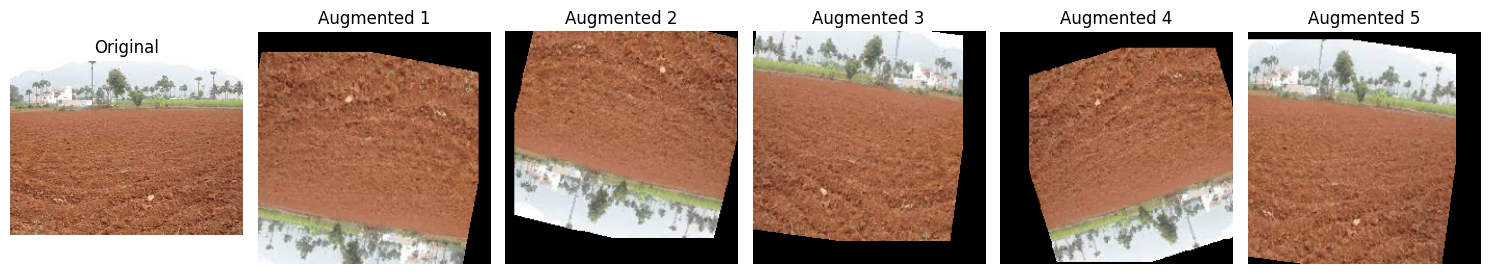

In [7]:
# We set up constants for our model training
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001
MODEL_NAME = 'resnet50'
OPTIMIZER_NAME = 'adam'

# Define class names and label mapping
class_names = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
label_mapping = {name: idx for idx, name in enumerate(class_names)}
inv_label_mapping = {idx: name for name, idx in label_mapping.items()}

# Append file extension if not present in image_id
if not train_df['image_id'].iloc[0].endswith('.jpg'):
    train_df['image_id'] = train_df['image_id'].apply(lambda x: x + '.jpg')
    test_df['image_id'] = test_df['image_id'].apply(lambda x: x + '.jpg')

# Map string labels to numeric for training
train_df['soil_label'] = train_df['soil_type'].map(label_mapping)

# We split our training data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['soil_label'], random_state=42)

# Compute class weights to handle any class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(NUM_CLASSES),
    y=train_df['soil_label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create our custom dataset class
class SoilDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_id']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            label = self.df.iloc[idx]['soil_label']
            return image, label

# Compute dataset-specific mean and std for normalization
def compute_dataset_stats(df, img_dir):
    pixel_sum = np.zeros(3)
    pixel_sum_sq = np.zeros(3)
    n_pixels = 0

    for idx in range(len(df)):
        img_name = df.iloc[idx]['image_id']
        img_path = os.path.join(img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            image = np.array(image.resize((IMAGE_SIZE, IMAGE_SIZE))) / 255.0
            pixel_sum += image.sum(axis=(0, 1))
            pixel_sum_sq += (image ** 2).sum(axis=(0, 1))
            n_pixels += image.shape[0] * image.shape[1]
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

    mean = pixel_sum / n_pixels
    std = np.sqrt(pixel_sum_sq / n_pixels - mean ** 2)
    return mean, std

# Calculate mean and std for our dataset
mean, std = compute_dataset_stats(train_df, TRAIN_IMG_DIR)
print(f"Dataset Mean: {mean}, Std: {std}")

# Define our data transformations - we're avoiding color augmentation
# since color is likely important for soil classification
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = val_transform

# Visualize our augmentations to ensure they're appropriate
def visualize_augmentations(img_path, num_augmentations=5):
    original_img = Image.open(img_path).convert('RGB')

    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_augmentations + 1, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')

    vis_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ])

    for i in range(num_augmentations):
        augmented = vis_transform(original_img)
        plt.subplot(1, num_augmentations + 1, i + 2)
        plt.imshow(augmented)
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show augmentation examples for each soil type
soil_types = sorted(train_df['soil_type'].unique())
for soil_type in soil_types:
    img_id = train_df[train_df['soil_type'] == soil_type]['image_id'].iloc[0]
    img_path = os.path.join(TRAIN_IMG_DIR, img_id)
    print(f"Augmentation Examples: {soil_type}")
    visualize_augmentations(img_path)

# Create our datasets
train_dataset = SoilDataset(train_df, TRAIN_IMG_DIR, transform=train_transform)
val_dataset = SoilDataset(val_df, TRAIN_IMG_DIR, transform=val_transform)
test_dataset = SoilDataset(test_df, TEST_IMG_DIR, transform=test_transform, is_test=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# HYPER PARAMETER TUNING USING 5 FOLD GRID SEARCH CROSS VALIDATION - COMMENTED OUT

In [8]:
# Note: We previously used cross-validation to find the best hyperparameters.
# That code is commented out as it takes a long time to run.
# The parameters we're using here (ResNet50 with Adam optimizer, learning rate 0.0001) 
# were determined to be optimal from that process

# THE BELOW CELL IS WHAT WE USED TO GET THE BEST MODEL - WE APPLIED GRID SEARCH CV WITH 5 FOLDS 
# TO FIND THE BEST COMBINATION OF HYPERPARAMETERS TO GET THE MAXIMUM F1-MIN
# THEN, WE FIND THE BEST CONFIGURATION AND THE MODEL WITH THOSE  HYPERPARAMETERS TO FIT 
# IN THE LIMIT OF 20 MINUTES TO RUN THE NOTEBOOK


# # Define the model architecture using transfer learning
# def create_model(num_classes, model_name='resnet50', pretrained=True):
#     if model_name == 'resnet50':
#         model = models.resnet50(weights='DEFAULT' if pretrained else None)
#         # Modify the final layer for our classification task
#         in_features = model.fc.in_features
#         model.fc = nn.Sequential(
#             nn.Dropout(0.3),  # Add dropout for regularization
#             nn.Linear(in_features, num_classes)
#         )
#     elif model_name == 'efficientnet_b3':
#         model = models.efficientnet_b3(weights='DEFAULT' if pretrained else None)
#         in_features = model.classifier[1].in_features
#         model.classifier = nn.Sequential(
#             nn.Dropout(0.3, inplace=True),
#             nn.Linear(in_features, num_classes)
#         )
#     else:
#         raise ValueError(f"Unsupported model: {model_name}")
    
#     return model

# # Define training function with one epoch
# def train_epoch(model, dataloader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     all_targets = []
#     all_preds = []
    
#     for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
#         inputs, targets = inputs.to(device), targets.to(device)
        
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
        
#         # Statistics
#         running_loss += loss.item() * inputs.size(0)
#         _, predicted = outputs.max(1)
#         total += targets.size(0)
#         correct += predicted.eq(targets).sum().item()
        
#         # Save for F1 calculation
#         all_targets.extend(targets.cpu().numpy())
#         all_preds.extend(predicted.cpu().numpy())
    
#     # Calculate metrics
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     f1_scores = f1_score(all_targets, all_preds, average=None)
#     f1_micro = f1_score(all_targets, all_preds, average='micro')
#     f1_macro = f1_score(all_targets, all_preds, average='macro')
#     f1_min = np.min(f1_scores)  # Competition metric
    
#     return {
#         'loss': epoch_loss,
#         'acc': epoch_acc,
#         'f1_scores': f1_scores,
#         'f1_micro': f1_micro,
#         'f1_macro': f1_macro,
#         'f1_min': f1_min
#     }

# # Define validation function
# def validate(model, dataloader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     all_targets = []
#     all_preds = []
#     all_probs = []
    
#     with torch.no_grad():
#         for inputs, targets in tqdm(dataloader, desc="Validating", leave=False):
#             inputs, targets = inputs.to(device), targets.to(device)
            
#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
            
#             # Statistics
#             running_loss += loss.item() * inputs.size(0)
#             _, predicted = outputs.max(1)
#             total += targets.size(0)
#             correct += predicted.eq(targets).sum().item()
            
#             # Save predictions and targets for metrics
#             all_targets.extend(targets.cpu().numpy())
#             all_preds.extend(predicted.cpu().numpy())
#             all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
#     # Calculate metrics
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     f1_scores = f1_score(all_targets, all_preds, average=None)
#     f1_micro = f1_score(all_targets, all_preds, average='micro')
#     f1_macro = f1_score(all_targets, all_preds, average='macro')
#     f1_min = np.min(f1_scores)  # Competition metric
    
#     # Create confusion matrix
#     cm = confusion_matrix(all_targets, all_preds)
    
#     # Classification report
#     class_names = [inv_label_mapping[i] for i in range(len(inv_label_mapping))]
#     report = classification_report(all_targets, all_preds, target_names=class_names)
    
#     return {
#         'loss': epoch_loss,
#         'acc': epoch_acc,
#         'f1_scores': f1_scores,
#         'f1_micro': f1_micro,
#         'f1_macro': f1_macro,
#         'f1_min': f1_min,
#         'confusion_matrix': cm,
#         'report': report,
#         'all_targets': all_targets,
#         'all_preds': all_preds,
#         'all_probs': all_probs
#     }

# # Function to make predictions on test set
# def predict(model, dataloader, device):
#     model.eval()
#     all_probs = []
    
#     with torch.no_grad():
#         for inputs in tqdm(dataloader, desc="Predicting"):
#             inputs = inputs.to(device)
#             outputs = model(inputs)
#             probs = torch.softmax(outputs, dim=1)
#             all_probs.extend(probs.cpu().numpy())
    
#     return np.array(all_probs)
# # Define hyperparameter grid
# param_grid = {
#     'model_name': ['resnet50', 'efficientnet_b3'],
#     'learning_rate': [0.001, 0.0001],
#     'batch_size': [16, 32],
#     'optimizer_name': ['adam', 'sgd']
# }

# # Create all combinations of hyperparameters
# import itertools
# param_combinations = list(itertools.product(
#     param_grid['model_name'],
#     param_grid['learning_rate'],
#     param_grid['batch_size'],
#     param_grid['optimizer_name']
# ))

# print(f"Total parameter combinations to try: {len(param_combinations)}")

# # Cross-validation setup
# n_splits = 5
# kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Initialize tracking variables
# best_params = None
# best_f1_min = 0.0
# cv_results = []
# Total parameter combinations to try: 16
# # Run grid search with cross-validation
# for model_name, learning_rate, batch_size, optimizer_name in param_combinations:
#     param_config = {
#         'model_name': model_name,
#         'learning_rate': learning_rate,
#         'batch_size': batch_size,
#         'optimizer_name': optimizer_name
#     }
#     print(f"\nTesting parameters: {param_config}")
    
#     # Track fold results
#     fold_f1_mins = []
#     fold_val_results = []
    
#     # Create cross-validation folds
#     for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, train_df['soil_label'])):
#         print(f"\nFold {fold+1}/{n_splits}")
        
#         # Split data
#         train_fold = train_df.iloc[train_idx].reset_index(drop=True)
#         val_fold = train_df.iloc[val_idx].reset_index(drop=True)
        
#         # Create datasets
#         train_dataset = SoilDataset(train_fold, TRAIN_IMG_DIR, transform=train_transform)
#         val_dataset = SoilDataset(val_fold, TRAIN_IMG_DIR, transform=val_transform)
        
#         # Create weighted sampler for training set
#         train_sampler = create_weighted_sampler(train_fold)
        
#         # Create data loaders
#         train_loader = DataLoader(
#             train_dataset, 
#             batch_size=batch_size, 
#             sampler=train_sampler,
#             num_workers=2
#         )
#         val_loader = DataLoader(
#             val_dataset, 
#             batch_size=batch_size, 
#             shuffle=False, 
#             num_workers=2
#         )
        
#         # Create model
#         num_classes = len(label_mapping)
#         model = create_model(num_classes, model_name=model_name)
#         model = model.to(device)
        
#         # Define loss function with class weights
#         criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        
#         # Define optimizer
#         if optimizer_name == 'adam':
#             optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#         else:  # SGD
#             optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
#         # Learning rate scheduler
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer, mode='max', factor=0.5, patience=2, verbose=True
#         )
        
#         # Early stopping setup
#         patience = 5
#         early_stop_counter = 0
#         best_val_f1_min = 0.0
#         best_model_state = None
        
#         # Train for a fixed number of epochs
#         num_epochs = 15
#         epoch_results = []
        
#         for epoch in range(num_epochs):
#             print(f"\nEpoch {epoch+1}/{num_epochs}")
            
#             # Train
#             train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
            
#             # Validate
#             val_metrics = validate(model, val_loader, criterion, device)
            
#             # Update scheduler based on validation f1_min
#             scheduler.step(val_metrics['f1_min'])
            
#             # Print metrics
#             print(f"Train Loss: {train_metrics['loss']:.4f}, Train Acc: {train_metrics['acc']:.4f}")
#             print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['acc']:.4f}")
#             print(f"Val F1 (min): {val_metrics['f1_min']:.4f}, Val F1 (macro): {val_metrics['f1_macro']:.4f}")
#             print(f"Val F1 per class: {[f'{f1:.4f}' for f1 in val_metrics['f1_scores']]}")
            
#             # Save epoch results
#             epoch_result = {
#                 'epoch': epoch + 1,
#                 'train_loss': train_metrics['loss'],
#                 'train_acc': train_metrics['acc'],
#                 'train_f1_min': train_metrics['f1_min'],
#                 'val_loss': val_metrics['loss'],
#                 'val_acc': val_metrics['acc'],
#                 'val_f1_min': val_metrics['f1_min'],
#                 'val_f1_macro': val_metrics['f1_macro'],
#                 'val_f1_scores': val_metrics['f1_scores']
#             }
#             epoch_results.append(epoch_result)
            
#             # Check for improvement
#             if val_metrics['f1_min'] > best_val_f1_min:
#                 best_val_f1_min = val_metrics['f1_min']
#                 best_model_state = copy.deepcopy(model.state_dict())
#                 early_stop_counter = 0
#             else:
#                 early_stop_counter += 1
            
#             # Early stopping
#             if early_stop_counter >= patience:
#                 print(f"Early stopping triggered after epoch {epoch+1}")
#                 break
        
#         # Record best result for this fold
#         fold_f1_mins.append(best_val_f1_min)
        
#         # Load best model state for final evaluation
#         model.load_state_dict(best_model_state)
#         final_val_metrics = validate(model, val_loader, criterion, device)
#         fold_val_results.append(final_val_metrics)
        
#         # Print final validation report
#         print("\nFinal Validation Performance:")
#         print(final_val_metrics['report'])
        
#         # Plot confusion matrix
#         plt.figure(figsize=(10, 8))
#         cm = final_val_metrics['confusion_matrix']
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#                     xticklabels=[inv_label_mapping[i] for i in range(len(inv_label_mapping))],
#                     yticklabels=[inv_label_mapping[i] for i in range(len(inv_label_mapping))])
#         plt.title(f'Confusion Matrix - Fold {fold+1}')
#         plt.ylabel('True Label')
#         plt.xlabel('Predicted Label')
#         plt.tight_layout()
#         plt.show()
        
#         # Clear GPU memory
#         del model
#         torch.cuda.empty_cache()
    
#     # Calculate average performance across folds
#     avg_f1_min = np.mean(fold_f1_mins)
#     print(f"\nAverage Min F1 across {n_splits} folds: {avg_f1_min:.4f}")
    
#     # Save results for this parameter configuration
#     param_result = {
#         'params': param_config,
#         'fold_f1_mins': fold_f1_mins,
#         'avg_f1_min': avg_f1_min
#     }
#     cv_results.append(param_result)
    
#     # Check if this is the best configuration so far
#     if avg_f1_min > best_f1_min:
#         best_f1_min = avg_f1_min
#         best_params = param_config
#         print(f"New best configuration found! F1-min: {best_f1_min:.4f}")

# # Show best parameters
# print("\nBest Parameters:")
# for param, value in best_params.items():
#     print(f"{param}: {value}")
# print(f"Best Average F1-min: {best_f1_min:.4f}")

# # Plot results comparison
# param_names = [f"{p['params']['model_name']}-{p['params']['optimizer_name']}-{p['params']['learning_rate']}-{p['params']['batch_size']}" 
#                for p in cv_results]
# avg_scores = [p['avg_f1_min'] for p in cv_results]

# plt.figure(figsize=(12, 6))
# bars = plt.bar(param_names, avg_scores, color='skyblue')
# plt.axhline(y=best_f1_min, color='r', linestyle='-', label=f'Best score: {best_f1_min:.4f}')
# plt.title("Cross-Validation Results: Average F1-min by Parameter Configuration", fontsize=15)
# plt.xlabel("Parameter Configuration", fontsize=12)
# plt.ylabel("Average F1-min", fontsize=12)
# plt.xticks(rotation=90)
# plt.ylim(0, 1)
# plt.grid(axis='y', alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()

# Create and train model (Using the best configuration found using above code)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]



Epoch 1/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.9576, Train Acc: 0.6950, Train F1 (macro): 0.6835
Val Loss: 0.3652, Val Acc: 0.8857, Val F1 (macro): 0.8838, Val F1 (min): 0.7955
Best model saved as 'best_resnet50.pth'

Epoch 2/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.3387, Train Acc: 0.8864, Train F1 (macro): 0.8838
Val Loss: 0.1769, Val Acc: 0.9510, Val F1 (macro): 0.9496, Val F1 (min): 0.8941
Best model saved as 'best_resnet50.pth'

Epoch 3/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.1748, Train Acc: 0.9355, Train F1 (macro): 0.9315
Val Loss: 0.1092, Val Acc: 0.9551, Val F1 (macro): 0.9543, Val F1 (min): 0.9091
Best model saved as 'best_resnet50.pth'

Epoch 4/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.1244, Train Acc: 0.9488, Train F1 (macro): 0.9459
Val Loss: 0.0977, Val Acc: 0.9633, Val F1 (macro): 0.9636, Val F1 (min): 0.9302
Best model saved as 'best_resnet50.pth'

Epoch 5/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.1078, Train Acc: 0.9611, Train F1 (macro): 0.9601
Val Loss: 0.0698, Val Acc: 0.9796, Val F1 (macro): 0.9796, Val F1 (min): 0.9639
Best model saved as 'best_resnet50.pth'

Epoch 6/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0784, Train Acc: 0.9683, Train F1 (macro): 0.9651
Val Loss: 0.1163, Val Acc: 0.9633, Val F1 (macro): 0.9624, Val F1 (min): 0.9195

Epoch 7/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0900, Train Acc: 0.9632, Train F1 (macro): 0.9604
Val Loss: 0.1198, Val Acc: 0.9714, Val F1 (macro): 0.9649, Val F1 (min): 0.9351

Epoch 8/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0946, Train Acc: 0.9713, Train F1 (macro): 0.9693
Val Loss: 0.0685, Val Acc: 0.9796, Val F1 (macro): 0.9796, Val F1 (min): 0.9639

Epoch 9/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0764, Train Acc: 0.9806, Train F1 (macro): 0.9805
Val Loss: 0.0773, Val Acc: 0.9755, Val F1 (macro): 0.9761, Val F1 (min): 0.9639

Epoch 10/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0373, Train Acc: 0.9846, Train F1 (macro): 0.9838
Val Loss: 0.0555, Val Acc: 0.9796, Val F1 (macro): 0.9802, Val F1 (min): 0.9756
Best model saved as 'best_resnet50.pth'

Epoch 11/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0322, Train Acc: 0.9908, Train F1 (macro): 0.9901
Val Loss: 0.0626, Val Acc: 0.9796, Val F1 (macro): 0.9802, Val F1 (min): 0.9756

Epoch 12/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0277, Train Acc: 0.9898, Train F1 (macro): 0.9896
Val Loss: 0.0662, Val Acc: 0.9796, Val F1 (macro): 0.9802, Val F1 (min): 0.9756

Epoch 13/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0297, Train Acc: 0.9918, Train F1 (macro): 0.9913
Val Loss: 0.0612, Val Acc: 0.9796, Val F1 (macro): 0.9794, Val F1 (min): 0.9524

Epoch 14/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0207, Train Acc: 0.9939, Train F1 (macro): 0.9937
Val Loss: 0.0635, Val Acc: 0.9755, Val F1 (macro): 0.9761, Val F1 (min): 0.9639

Epoch 15/15


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.0192, Train Acc: 0.9959, Train F1 (macro): 0.9953
Val Loss: 0.0617, Val Acc: 0.9796, Val F1 (macro): 0.9802, Val F1 (min): 0.9756
Early stopping triggered after epoch 15


Validating:   0%|          | 0/8 [00:00<?, ?it/s]


Final Validation Performance:
Accuracy: 0.9796
F1 Score (macro): 0.9802
F1 Score (min): 0.9756

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.99      0.96      0.98       106
   Black Soil       0.96      1.00      0.98        46
    Clay soil       0.95      1.00      0.98        40
     Red soil       1.00      0.98      0.99        53

     accuracy                           0.98       245
    macro avg       0.98      0.99      0.98       245
 weighted avg       0.98      0.98      0.98       245



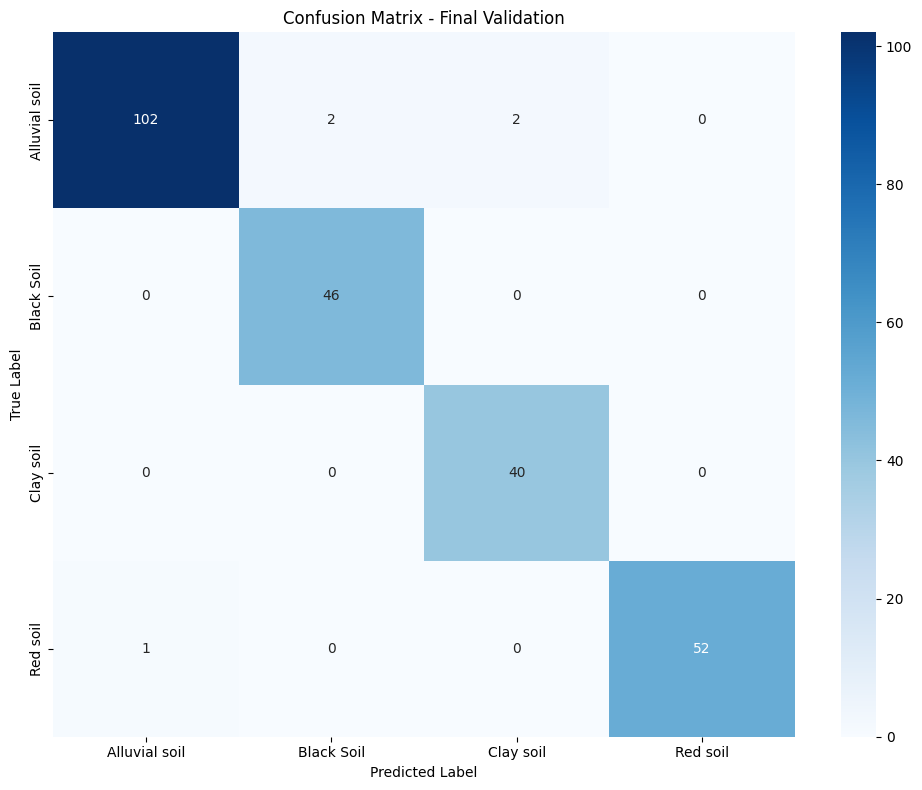

In [9]:
# We define our model architecture using transfer learning with ResNet50
def create_model(num_classes, model_name='resnet50', pretrained=True):
    if model_name == 'resnet50':
        model = models.resnet50(weights='DEFAULT' if pretrained else None)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),  # Add dropout for regularization
            nn.Linear(in_features, num_classes)
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    return model

# Define training function for one epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    
    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    f1_min = np.min(f1_score(all_targets, all_preds, average=None))
    
    return {
        'loss': epoch_loss,
        'acc': epoch_acc,
        'f1_macro': f1_macro,
        'f1_min': f1_min
    }

# Define validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Calculate statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    f1_min = np.min(f1_score(all_targets, all_preds, average=None))
    cm = confusion_matrix(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, target_names=class_names)
    
    return {
        'loss': epoch_loss,
        'acc': epoch_acc,
        'f1_macro': f1_macro,
        'f1_min': f1_min,
        'confusion_matrix': cm,
        'report': report
    }

# Create model
model = create_model(NUM_CLASSES, model_name=MODEL_NAME)
model = model.to(device)

# Define loss function with class weights to handle any imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler to reduce LR when performance plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# Early stopping setup to prevent overfitting
patience = 5
early_stop_counter = 0
best_val_f1_min = 0.0
best_model_state = None

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train one epoch
    train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_metrics = validate(model, val_loader, criterion, device)
    
    # Update scheduler based on validation F1-min score
    scheduler.step(val_metrics['f1_min'])
    
    # Print metrics
    print(f"Train Loss: {train_metrics['loss']:.4f}, Train Acc: {train_metrics['acc']:.4f}, Train F1 (macro): {train_metrics['f1_macro']:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['acc']:.4f}, Val F1 (macro): {val_metrics['f1_macro']:.4f}, Val F1 (min): {val_metrics['f1_min']:.4f}")
    
    # Check for improvement
    if val_metrics['f1_min'] > best_val_f1_min:
        best_val_f1_min = val_metrics['f1_min']
        best_model_state = model.state_dict()
        early_stop_counter = 0
        # Save best model
        torch.save(best_model_state, 'best_resnet50.pth')
        print("Best model saved as 'best_resnet50.pth'")
    else:
        early_stop_counter += 1
    
    # Early stopping
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after epoch {epoch+1}")
        break

# Load best model for final evaluation
model.load_state_dict(best_model_state)

# Final validation
val_metrics = validate(model, val_loader, criterion, device)
print("\nFinal Validation Performance:")
print(f"Accuracy: {val_metrics['acc']:.4f}")
print(f"F1 Score (macro): {val_metrics['f1_macro']:.4f}")
print(f"F1 Score (min): {val_metrics['f1_min']:.4f}")
print("\nClassification Report:")
print(val_metrics['report'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Final Validation')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Make predictions on test set

Making predictions on test set...


Predicting:   0%|          | 0/11 [00:00<?, ?it/s]


Sample of test predictions:
            image_id      soil_type
0  img_cdf80d6f.jpeg  Alluvial soil
1   img_c0142a80.jpg  Alluvial soil
2   img_91168fb0.jpg  Alluvial soil
3   img_9822190f.jpg  Alluvial soil
4  img_e5fc436c.jpeg  Alluvial soil
5   img_3d6e64a1.jpg  Alluvial soil
6  img_ccb81e64.jpeg  Alluvial soil
7  img_9a499fc5.jpeg  Alluvial soil
8  img_b957da08.jpeg  Alluvial soil
9   img_c62bd1a1.jpg  Alluvial soil


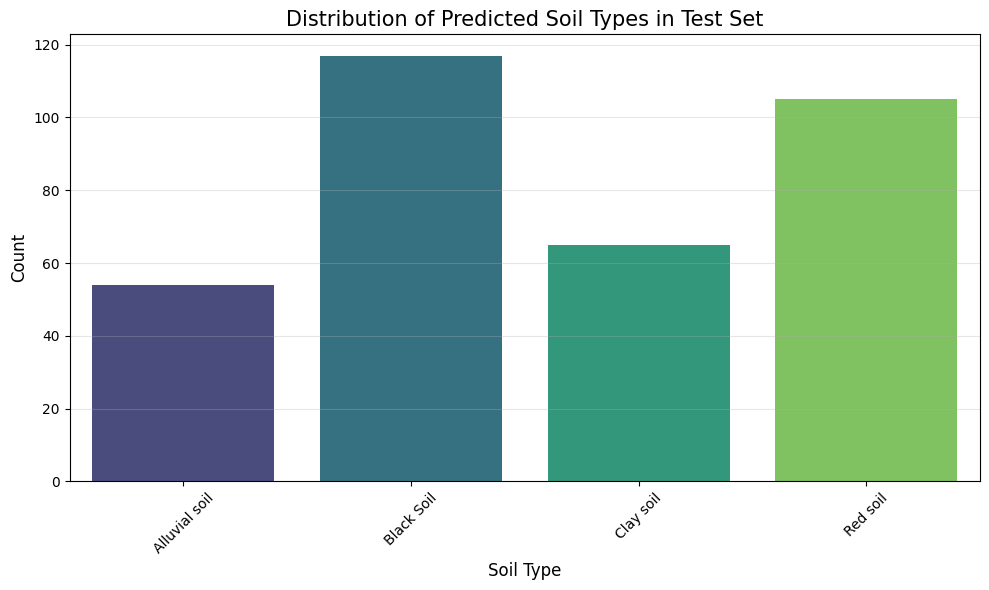

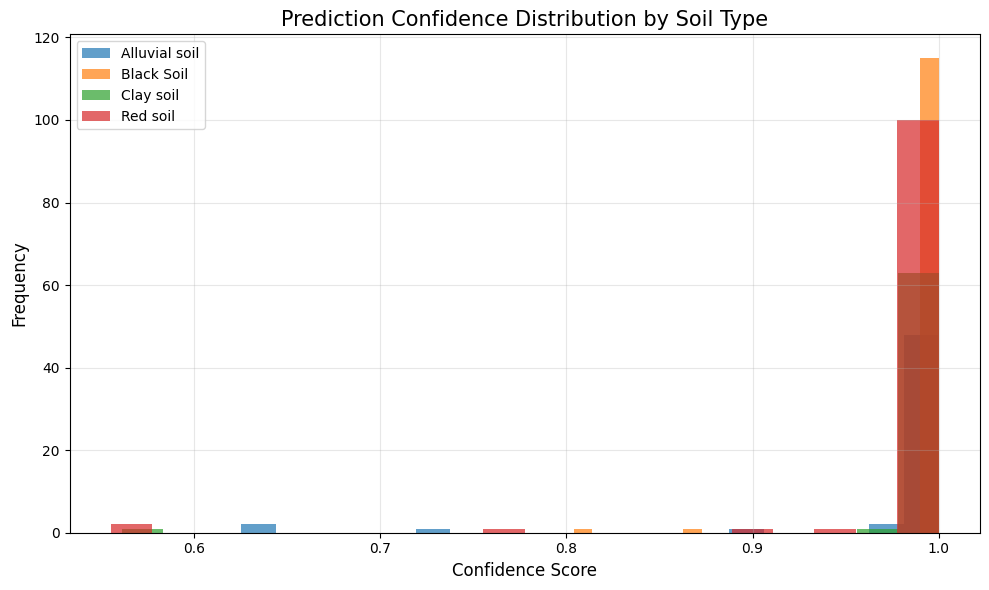

Submission file saved to 'submission.csv'


In [10]:
# Define prediction function
def predict(model, dataloader, device):
    model.eval()
    all_probs = []
    
    with torch.no_grad():
        for inputs in tqdm(dataloader, desc="Predicting"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_probs)

# Make predictions on test set
print("Making predictions on test set...")
test_probs = predict(model, test_loader, device) 
test_preds = np.argmax(test_probs, axis=1)

# Convert numeric predictions to soil type labels
test_pred_labels = [inv_label_mapping[pred] for pred in test_preds]

# Create submission dataframe
submission_df = pd.DataFrame({
    'image_id': test_df['image_id'],
    'soil_type': test_pred_labels
})

# Check sample of predictions
print("\nSample of test predictions:")
print(submission_df.head(10))

# Visualize distribution of predictions in test set
plt.figure(figsize=(10, 6))
sns.countplot(x=test_pred_labels, palette='viridis')
plt.title('Distribution of Predicted Soil Types in Test Set', fontsize=15)
plt.xlabel('Soil Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze prediction confidence
test_max_probs = np.max(test_probs, axis=1)

plt.figure(figsize=(10, 6))
for soil_type in sorted(label_mapping.keys()):
    class_indices = [j for j, label in enumerate(test_pred_labels) if label == soil_type]
    class_probs = [test_max_probs[j] for j in class_indices]
    plt.hist(class_probs, alpha=0.7, bins=20, label=soil_type)

plt.title('Prediction Confidence Distribution by Soil Type', fontsize=15)
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved to 'submission.csv'")